In [145]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import numpy as np
import foolbox
from torch.utils.data import WeightedRandomSampler

In [146]:
train_dataset.train_labels
class_weights = []
for l in train_dataset.train_labels:
    if l != 8:
        class_weights.append(1)
    else:
        class_weights.append(0.005)

# Train VAE with the digit class 8 acting as anomalous

In [147]:
bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),]),
                               download=True)

test_dataset = datasets.MNIST(root='./mnist_data/', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(), ]),
                               download=False)

# Data Loader (Input Pipeline)
train_sampler = WeightedRandomSampler(weights=class_weights, num_samples=len(train_dataset.train_labels), replacement=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=False, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [153]:
lab_counts = [0 for _ in range(10)]
for i, (data, label) in enumerate(train_loader):
    #print(label)
    for l in label:
        lab_counts[l] += 1

In [154]:
lab_counts

[6505, 7492, 6594, 6746, 6484, 6042, 6553, 6929, 30, 6625]

In [155]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var, z

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=10)
if torch.cuda.is_available():
    vae.cuda()

In [156]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=10, bias=True)
  (fc32): Linear(in_features=256, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [157]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD, BCE, KLD

In [158]:
%matplotlib inline
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var, _ = vae(data)
        loss, bc, kld = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        #print(recon_batch.shape)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tKLD: {:.4f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data), kld.item() / len(data)))
            #plt.imshow(data[0].cpu().squeeze().detach().numpy(), cmap='gray')
            #plt.imshow(recon_batch[0].view((-1, 28, 28)).cpu().squeeze().detach().numpy(), cmap='gray')
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    plt.subplot(2,1,1)
    plt.imshow(data[0].cpu().squeeze().detach().numpy(), cmap='gray')
    plt.subplot(2,1,2)
    plt.imshow(recon_batch[0].view((-1, 28, 28)).cpu().squeeze().detach().numpy(), cmap='gray')

In [159]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var, _ = vae(data)
            
            # sum up batch loss
            l, b, k = loss_function(recon, data, mu, log_var)
            test_loss += l.item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    plt.subplot(2,1,1)
    plt.imshow(data[0].cpu().squeeze().detach().numpy(), cmap='gray')
    plt.subplot(2,1,2)
    plt.imshow(recon[0].view((-1, 28, 28)).cpu().squeeze().detach().numpy(), cmap='gray')

In [160]:
ckpt_name = 'vae_anom_8_ckpt_30.pt'

Train Epoch: 1 [0/60000 (0%)]	Loss: 100.908418	KLD: 17.5873
Train Epoch: 1 [10000/60000 (17%)]	Loss: 105.355801	KLD: 17.5929
Train Epoch: 1 [20000/60000 (33%)]	Loss: 102.839922	KLD: 17.7572
Train Epoch: 1 [30000/60000 (50%)]	Loss: 102.172139	KLD: 17.0014
Train Epoch: 1 [40000/60000 (67%)]	Loss: 99.624619	KLD: 17.9808
Train Epoch: 1 [50000/60000 (83%)]	Loss: 98.680127	KLD: 17.0581
====> Epoch: 1 Average loss: 102.0986
====> Test set loss: 108.6256
Train Epoch: 2 [0/60000 (0%)]	Loss: 98.974785	KLD: 16.8114
Train Epoch: 2 [10000/60000 (17%)]	Loss: 100.496553	KLD: 17.2889
Train Epoch: 2 [20000/60000 (33%)]	Loss: 100.881660	KLD: 17.7237
Train Epoch: 2 [30000/60000 (50%)]	Loss: 102.076338	KLD: 17.2894
Train Epoch: 2 [40000/60000 (67%)]	Loss: 102.811660	KLD: 16.7491
Train Epoch: 2 [50000/60000 (83%)]	Loss: 99.817500	KLD: 17.0936
====> Epoch: 2 Average loss: 101.1890
====> Test set loss: 108.0966
Train Epoch: 3 [0/60000 (0%)]	Loss: 102.226914	KLD: 17.6637
Train Epoch: 3 [10000/60000 (17%)]	Los

Train Epoch: 19 [20000/60000 (33%)]	Loss: 97.954033	KLD: 19.0060
Train Epoch: 19 [30000/60000 (50%)]	Loss: 93.215479	KLD: 18.7486
Train Epoch: 19 [40000/60000 (67%)]	Loss: 91.775547	KLD: 18.2931
Train Epoch: 19 [50000/60000 (83%)]	Loss: 92.670029	KLD: 18.1153
====> Epoch: 19 Average loss: 95.9928
====> Test set loss: 104.0275
Train Epoch: 20 [0/60000 (0%)]	Loss: 94.277959	KLD: 18.6022
Train Epoch: 20 [10000/60000 (17%)]	Loss: 96.284502	KLD: 18.6014
Train Epoch: 20 [20000/60000 (33%)]	Loss: 98.658516	KLD: 19.0083
Train Epoch: 20 [30000/60000 (50%)]	Loss: 98.502949	KLD: 18.7495
Train Epoch: 20 [40000/60000 (67%)]	Loss: 98.136787	KLD: 18.6664
Train Epoch: 20 [50000/60000 (83%)]	Loss: 94.251660	KLD: 19.1379
====> Epoch: 20 Average loss: 95.8773
====> Test set loss: 104.1605
Train Epoch: 21 [0/60000 (0%)]	Loss: 89.380518	KLD: 18.3025
Train Epoch: 21 [10000/60000 (17%)]	Loss: 91.794512	KLD: 18.2696
Train Epoch: 21 [20000/60000 (33%)]	Loss: 96.748281	KLD: 19.2587
Train Epoch: 21 [30000/60000 

Train Epoch: 37 [30000/60000 (50%)]	Loss: 97.348955	KLD: 19.4318
Train Epoch: 37 [40000/60000 (67%)]	Loss: 96.970039	KLD: 19.4422
Train Epoch: 37 [50000/60000 (83%)]	Loss: 89.153545	KLD: 18.2664
====> Epoch: 37 Average loss: 94.3535
====> Test set loss: 103.5909
Train Epoch: 38 [0/60000 (0%)]	Loss: 94.363779	KLD: 18.3304
Train Epoch: 38 [10000/60000 (17%)]	Loss: 96.318281	KLD: 18.6764
Train Epoch: 38 [20000/60000 (33%)]	Loss: 94.404512	KLD: 18.9234
Train Epoch: 38 [30000/60000 (50%)]	Loss: 99.521543	KLD: 19.7579
Train Epoch: 38 [40000/60000 (67%)]	Loss: 92.409414	KLD: 19.3938
Train Epoch: 38 [50000/60000 (83%)]	Loss: 94.411348	KLD: 19.0631
====> Epoch: 38 Average loss: 94.2735
====> Test set loss: 103.8261
Train Epoch: 39 [0/60000 (0%)]	Loss: 92.596045	KLD: 18.7324
Train Epoch: 39 [10000/60000 (17%)]	Loss: 92.775020	KLD: 18.5819
Train Epoch: 39 [20000/60000 (33%)]	Loss: 97.667187	KLD: 19.3217
Train Epoch: 39 [30000/60000 (50%)]	Loss: 93.114541	KLD: 18.9535
Train Epoch: 39 [40000/60000 

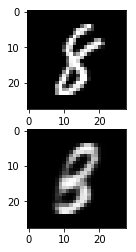

In [162]:
# Check for checkpoint.
if not os.path.isdir('mnist_clf/'):
    os.makedirs('mnist_clf/')
files = os.listdir('mnist_clf/')
if ckpt_name not in files:
    for epoch in range(1, 51):
        train(epoch)
        test()
        # Save the model
        #os.makedirs('mnist_clf/', exist_ok=True)
        torch.save(vae.state_dict(), os.path.join('mnist_clf', ckpt_name))
else:
    # Load the model
    vae.load_state_dict(torch.load(os.path.join('mnist_clf', ckpt_name)))

In [163]:
with torch.no_grad():
    z = torch.randn(64, 10).cuda()
    sample = vae.decoder(z).cuda()
    
    save_image(sample.view(64, 1, 28, 28), './mnist_samples/sample_anom8' + '.png')
    #imgs = make_grid(sample)

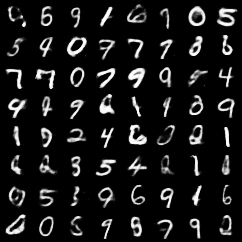

In [164]:
from IPython.display import display, Image
display(Image(filename='mnist_samples/sample_anom8.png'))

# Analyze Test Images

In [165]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

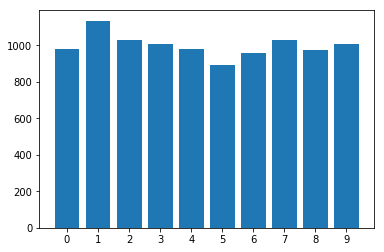

In [166]:
plt.bar(range(10), np.bincount(test_dataset.test_labels));
plt.xticks(range(10));

In [167]:
mse_obj = nn.MSELoss()

In [168]:
from scipy.stats import multivariate_normal

In [169]:
def find_prob(mu):
    # Here we find the probability of a particular latent variable
    # coming from a standard Normal N(0,I). We just use the mu value
    # we get. This is because the latent distribution is supposed
    # to be N(mu, var), and expectation of this is simply mu.

    probs = multivariate_normal.pdf(mu.data.cpu().numpy().transpose())
    #mean_probs_dims = np.mean(probs)

    #prob = multivariate_normal.pdf(mu.data.numpy().transpose(), mean=np.zeros(128), cov=np.eye(128))

    mean_probs_dims = np.sum(np.log(probs))
    return probs, mean_probs_dims

In [170]:
loss_ = {}
kld_ = {}
bce_ = {}
mse_ = {}
var_ = {}
probs_ = {}
norm_mse = []
anom_mse = []
X_test_encoded = []
anomaly_encoded = []
for i in range(10):
    bce_[i] = []
    kld_[i] = []
    mse_[i] = []
    var_[i] = []
    probs_[i] = []
    loss_[i] = []
for data, label in test_loader:
    data = data.cuda()
    #print(label)
    #break
    recon, mu, log_var, z = vae(data)
    # sum up batch loss
    l, b, k = loss_function(recon, data, mu, log_var)
    #test_loss += l.item()
    #print(label.item())
    #break
    #print(data)
    #print(recon)
    #break
    bce_[label.item()].append(b.item())
    kld_[label.item()].append(k.item())
    mse_[label.item()].append(mse_obj(data.view(-1, 784), recon).item())
    var_[label.item()].append(log_var.exp().mean().item())
    _, mean_prob = find_prob(mu)
    probs_[label.item()].append(-mean_prob.item())
    loss_[label.item()].append(l.item())
    if label.item() == 8:
        anomaly_encoded.append(z.data.cpu().numpy())
        anom_mse.append(mse_obj(data.view(-1, 784), recon).item())
    else:
        X_test_encoded.append(z.data.cpu().numpy())
        norm_mse.append(mse_obj(data.view(-1, 784), recon).item())

In [171]:
prob_mean = [np.mean(probs_[k]) for k in probs_]
prob_err = [np.std(probs_[k]) for k in probs_]

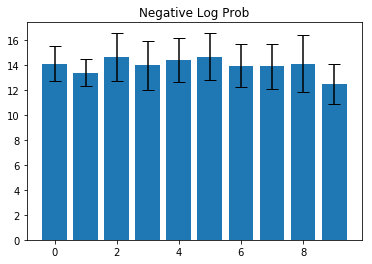

In [192]:
plt.bar(range(10), prob_mean, yerr=prob_err, capsize=6);
plt.title('Negative Log Prob');

In [173]:
var_mean = [np.mean(var_[k]) for k in var_]
var_err = [np.std(var_[k]) for k in var_]

In [193]:
plt.bar(range(10), var_mean, yerr=var_err, capsize=6);
plt.title('Variance');

In [175]:
mse_mean = [np.mean(mse_[k]) for k in mse_]
mse_err = [np.std(mse_[k]) for k in mse_]

In [194]:
plt.bar(range(10), mse_mean, yerr=mse_err, capsize=6);
plt.title('MSE Error');

In [177]:
klds_mean = [np.mean(kld_[k]) for k in kld_]
klds_err = [np.std(kld_[k]) for k in kld_]

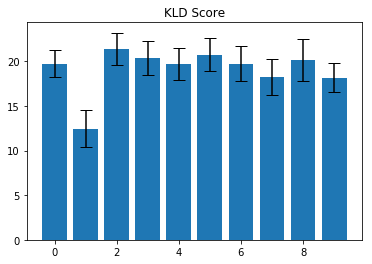

In [195]:
plt.bar(range(10), klds_mean, yerr=klds_err, capsize=6);
plt.title('KLD Score');

In [179]:
bce_mean = [np.mean(bce_[k]) for k in bce_]
bce_err = [np.std(bce_[k]) for k in bce_]

In [196]:
plt.bar(range(10), bce_mean, yerr=bce_err, capsize=6);
plt.title('BCE');

In [181]:
loss_mean = [np.mean(loss_[k]) for k in loss_]
loss_err = [np.std(loss_[k]) for k in loss_]

In [182]:
plt.bar(range(10), loss_mean, yerr=loss_err, capsize=6)

<BarContainer object of 10 artists>

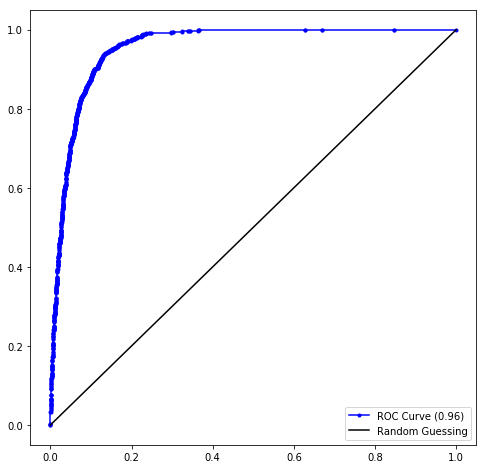

In [183]:
from sklearn.metrics import roc_auc_score, roc_curve
mse_score = np.concatenate([norm_mse, anom_mse],0)
true_label = [0]*len(norm_mse)+[1]*len(anom_mse)
if roc_auc_score(true_label, mse_score)<0.5:
    mse_score *= -1
fpr, tpr, thresholds = roc_curve(true_label, mse_score)
auc_score = roc_auc_score(true_label, mse_score)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve (%2.2f)' %  auc_score)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend();

In [184]:
norm_kld, anom_kld = [], []
for k in kld_:
    if k == 8:
        anom_kld += kld_[k]
    else:
        norm_kld += kld_[k]

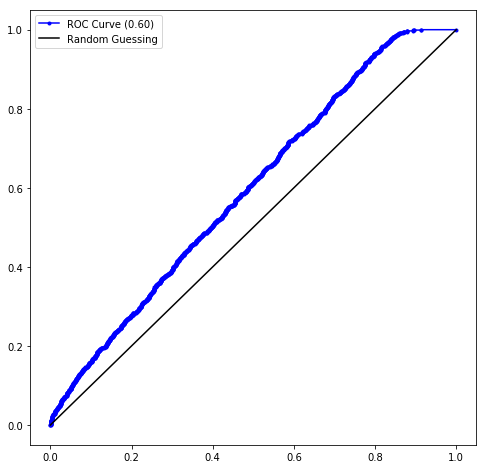

In [185]:
mse_score = np.concatenate([norm_kld, anom_kld],0)
true_label = [0]*len(norm_kld)+[1]*len(anom_kld)
if roc_auc_score(true_label, mse_score)<0.5:
    mse_score *= -1
fpr, tpr, thresholds = roc_curve(true_label, mse_score)
auc_score = roc_auc_score(true_label, mse_score)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve (%2.2f)' %  auc_score)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend();

In [187]:
norm_prob, anom_prob = [], []
for k in probs_:
    if k == 8:
        anom_prob += probs_[k]
    else:
        norm_prob += probs_[k]

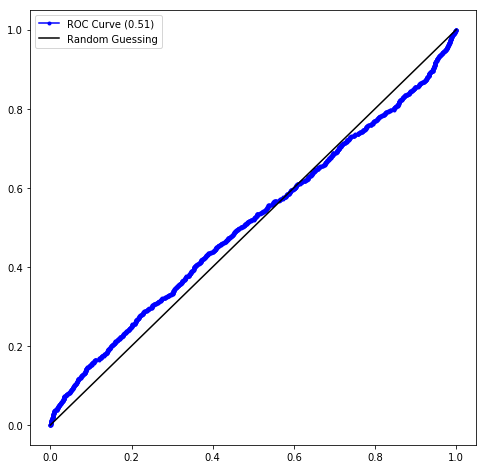

In [188]:
mse_score = np.concatenate([norm_prob, anom_prob],0)
true_label = [0]*len(norm_prob)+[1]*len(anom_prob)
if roc_auc_score(true_label, mse_score)<0.5:
    mse_score *= -1
fpr, tpr, thresholds = roc_curve(true_label, mse_score)
auc_score = roc_auc_score(true_label, mse_score)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve (%2.2f)' %  auc_score)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend();

In [189]:
norm_var, anom_var = [], []
for k in var_:
    if k == 8:
        anom_var += var_[k]
    else:
        norm_var += var_[k]

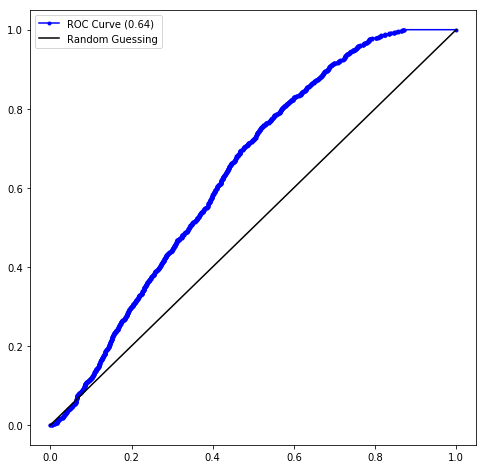

In [190]:
mse_score = np.concatenate([norm_var, anom_var],0)
true_label = [0]*len(norm_var)+[1]*len(anom_var)
if roc_auc_score(true_label, mse_score)<0.5:
    mse_score *= -1
fpr, tpr, thresholds = roc_curve(true_label, mse_score)
auc_score = roc_auc_score(true_label, mse_score)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve (%2.2f)' %  auc_score)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend();